# 04.6a4 Structural Subspace Orthogonality

**Question:** Does "structure ⊥ content" generalize beyond the three brightest quasars?

From 04.6a3, we found that the three extreme quasars (`<|endoftext|>`, `\n`, `\u200b\u200b`) are causally orthogonal to the main sequence. But these are just 3 tokens out of potentially dozens of structural tokens.

**Hypothesis:** ALL structural tokens (special tokens, control characters, whitespace, formatting markers) occupy a subspace that is causally orthogonal to semantic content.

## Method

1. **Identify structural tokens** via multiple criteria:
   - Official special tokens from tokenizer metadata
   - Whitespace-only tokens
   - Control characters (Unicode category C*)
   - Zero-width and formatting characters
   - Special token markers (`<|...|>`)

2. **Extract main sequence** (as in 04.6a3):
   - Top K tokens closest to mean causal norm (~54 logometers)

3. **Compute projections** using causal inner product:
   - Main sequence → structural tokens
   - Structural → main sequence
   - Random tokens → structural tokens (control)

4. **Statistical test**:
   - Compare projection magnitudes
   - Ratio test: structural/control
   - If ratio << 1, confirms orthogonality

## If This Works

We'll have evidence that the model learned a general principle:

**Structural information (boundaries, formatting, control flow) should be geometrically independent from semantic content (meaning, concepts, facts).**

This would be a profound finding about how language models organize their internal representations.

## Configuration

In [1]:
import torch
import numpy as np
import unicodedata
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and paths
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
METRIC_PATH = Path("../data/vectors/causal_metric_tensor_qwen3_4b.pt")

# Analysis parameters
K_MAIN_SEQUENCE = 100  # Number of main sequence tokens to test
K_CONTROL = 100        # Number of random tokens for control
RANDOM_SEED = 42

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Load Model, Tokenizer, and Metric Tensor

In [2]:
# Load metric tensor
print("Loading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, map_location=device, weights_only=True)
M = metric_data['M']
print(f"M shape: {M.shape}")
print()

# Load model for gamma matrix
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Extract gamma (unembedding matrix)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape
print(f"Gamma shape: {gamma.shape}")
print(f"Vocabulary size: {vocab_size:,} tokens")
print()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loading causal metric tensor...
M shape: torch.Size([2560, 2560])

Loading Qwen/Qwen3-4B-Instruct-2507...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gamma shape: torch.Size([151936, 2560])
Vocabulary size: 151,936 tokens

Tokenizer loaded.


## Identify Structural Tokens

We'll use multiple criteria to cast a wide net.

In [3]:
def is_structural_token(token_id, tokenizer):
    """
    Determine if a token is structural (non-semantic) based on multiple criteria.
    
    Returns: (bool, str) - (is_structural, reason)
    """
    token_str = tokenizer.decode([token_id])
    
    # 1. Official special tokens
    if token_id in tokenizer.all_special_ids:
        return True, "special_token"
    
    # 2. Whitespace only (includes newline, tab, spaces)
    if token_str.strip() == '' and len(token_str) > 0:
        return True, "whitespace"
    
    # 3. Special token markers <|...|>
    if token_str.startswith('<|') and token_str.endswith('|>'):
        return True, "marker_format"
    
    # 4. Control characters (Unicode category Cc, Cf, etc.)
    if any(unicodedata.category(c).startswith('C') for c in token_str):
        return True, "control_char"
    
    # 5. Zero-width and formatting characters
    zero_width = ['\u200b', '\u200c', '\u200d', '\ufeff', '\u2060', '\u180e']
    if any(zw in token_str for zw in zero_width):
        return True, "zero_width"
    
    # 6. Other common formatting
    formatting = ['\xa0']  # Non-breaking space
    if any(fmt in token_str for fmt in formatting):
        return True, "formatting"
    
    return False, "semantic"

# Scan all tokens
print("Scanning vocabulary for structural tokens...")
structural_tokens = []
structural_reasons = []

for token_id in range(vocab_size):
    is_struct, reason = is_structural_token(token_id, tokenizer)
    if is_struct:
        structural_tokens.append(token_id)
        structural_reasons.append(reason)

print(f"\nFound {len(structural_tokens)} structural tokens ({len(structural_tokens)/vocab_size:.2%} of vocabulary)")
print()

# Breakdown by category
from collections import Counter
reason_counts = Counter(structural_reasons)
print("Breakdown by category:")
for reason, count in reason_counts.most_common():
    print(f"  {reason:20s}: {count:5d} tokens")

structural_token_ids = torch.tensor(structural_tokens, device=device)

Scanning vocabulary for structural tokens...

Found 3661 structural tokens (2.41% of vocabulary)

Breakdown by category:
  control_char        :  3200 tokens
  whitespace          :   441 tokens
  special_token       :    14 tokens
  marker_format       :     6 tokens


## Examine Sample Structural Tokens

In [4]:
# Show first 20 structural tokens as examples
print("Sample structural tokens:")
print("="*80)
for i, (token_id, reason) in enumerate(zip(structural_tokens[:20], structural_reasons[:20])):
    token_str = tokenizer.decode([token_id])
    token_repr = repr(token_str)
    print(f"{i+1:2d}. ID {token_id:6d} | {reason:15s} | {token_repr}")

print()
print(f"(Showing first 20 of {len(structural_tokens)} total)")

Sample structural tokens:
 1. ID    188 | control_char    | '\x00'
 2. ID    189 | control_char    | '\x01'
 3. ID    190 | control_char    | '\x02'
 4. ID    191 | control_char    | '\x03'
 5. ID    192 | control_char    | '\x04'
 6. ID    193 | control_char    | '\x05'
 7. ID    194 | control_char    | '\x06'
 8. ID    195 | control_char    | '\x07'
 9. ID    196 | control_char    | '\x08'
10. ID    197 | whitespace      | '\t'
11. ID    198 | whitespace      | '\n'
12. ID    199 | whitespace      | '\x0b'
13. ID    200 | whitespace      | '\x0c'
14. ID    201 | whitespace      | '\r'
15. ID    202 | control_char    | '\x0e'
16. ID    203 | control_char    | '\x0f'
17. ID    204 | control_char    | '\x10'
18. ID    205 | control_char    | '\x11'
19. ID    206 | control_char    | '\x12'
20. ID    207 | control_char    | '\x13'

(Showing first 20 of 3661 total)


## Compute Causal Norms for All Tokens

In [5]:
# Compute causal norms
print("Computing causal norms for all tokens...")
gamma_M = gamma @ M  # [vocab_size, hidden_dim]
causal_norms_squared = (gamma_M * gamma).sum(dim=1)  # [vocab_size]
causal_norms = torch.sqrt(torch.clamp(causal_norms_squared, min=0))  # [vocab_size]

mean_norm = causal_norms.mean().item()
print(f"Mean causal norm: {mean_norm:.4f} logometers")
print()

Computing causal norms for all tokens...
Mean causal norm: 54.1318 logometers



## Extract Main Sequence Tokens

Top K tokens closest to mean causal norm (~54 logometers).

In [6]:
# Find tokens closest to mean norm
deviations = torch.abs(causal_norms - mean_norm)
main_seq_indices = torch.argsort(deviations)[:K_MAIN_SEQUENCE]

print(f"Main sequence: top {K_MAIN_SEQUENCE} tokens closest to mean norm")
print(f"  Mean deviation: {deviations[main_seq_indices].mean().item():.4f} logometers")
print()

# Show examples
print("Sample main sequence tokens:")
print("="*80)
for i, idx in enumerate(main_seq_indices[:10]):
    token_id = idx.item()
    norm = causal_norms[idx].item()
    token_str = tokenizer.decode([token_id])
    token_repr = repr(token_str)
    print(f"{i+1:2d}. ID {token_id:6d} | {norm:7.4f} logometers | {token_repr}")
print()

# Extract vectors
main_seq_vectors = gamma[main_seq_indices]  # [K, hidden_dim]

Main sequence: top 100 tokens closest to mean norm
  Mean deviation: 0.0021 logometers

Sample main sequence tokens:
 1. ID  51704 | 54.1319 logometers | 'UniformLocation'
 2. ID 129969 | 54.1318 logometers | 'ıldı'
 3. ID  92698 | 54.1317 logometers | 'Downloader'
 4. ID 139127 | 54.1320 logometers | ' hộp'
 5. ID  77581 | 54.1320 logometers | ' Pluto'
 6. ID 118802 | 54.1320 logometers | '强硬'
 7. ID  69473 | 54.1315 logometers | '_fg'
 8. ID  47686 | 54.1322 logometers | ' prejudice'
 9. ID 124119 | 54.1315 logometers | 'にな'
10. ID 132459 | 54.1323 logometers | ' достат'



## Random Control Tokens

Sample random tokens (excluding structural and main sequence) for baseline comparison.

In [7]:
# Create mask of available tokens (not structural, not main sequence)
torch.manual_seed(RANDOM_SEED)

all_indices = torch.arange(vocab_size, device=device)
excluded = torch.cat([structural_token_ids, main_seq_indices])

# Create mask
mask = torch.ones(vocab_size, dtype=torch.bool, device=device)
mask[excluded] = False
available_indices = all_indices[mask]

# Random sample
perm = torch.randperm(len(available_indices))[:K_CONTROL]
control_indices = available_indices[perm]

print(f"Control: {K_CONTROL} random typical semantic tokens")
print(f"  (Excluding {len(structural_tokens)} structural + {K_MAIN_SEQUENCE} main sequence)")
print()

# Extract vectors
control_vectors = gamma[control_indices]  # [K, hidden_dim]

Control: 100 random typical semantic tokens
  (Excluding 3661 structural + 100 main sequence)



## Compute Causal Projections

For each structural token, measure how much main sequence and control tokens project onto it using the causal inner product.

In [8]:
print("Computing causal projections...")
print()

# We'll compute mean projection onto each structural token,
# then average across all structural tokens

structural_vectors = gamma[structural_token_ids]  # [N_struct, hidden_dim]
n_structural = len(structural_token_ids)

print(f"Computing projections for {n_structural} structural tokens...")

main_seq_projections_all = []
control_projections_all = []

# For each structural token
for i, struct_idx in enumerate(structural_token_ids):
    if (i + 1) % 100 == 0:
        print(f"  Processing {i+1}/{n_structural}...")
    
    struct_vec = gamma[struct_idx]  # [hidden_dim]
    
    # Causal norm of structural token
    struct_norm = causal_norms[struct_idx]
    
    # Main sequence projections: (v^T M q) / ||q||_M
    v_M = main_seq_vectors @ M  # [K, hidden_dim]
    causal_dot = (v_M * struct_vec).sum(dim=1)  # [K]
    projections_main = causal_dot / struct_norm  # [K]
    main_seq_projections_all.append(projections_main.abs().mean().item())
    
    # Control projections
    v_M_control = control_vectors @ M  # [K, hidden_dim]
    causal_dot_control = (v_M_control * struct_vec).sum(dim=1)  # [K]
    projections_control = causal_dot_control / struct_norm  # [K]
    control_projections_all.append(projections_control.abs().mean().item())

print()
print("Projection computation complete.")

Computing causal projections...

Computing projections for 3661 structural tokens...
  Processing 100/3661...
  Processing 200/3661...
  Processing 300/3661...
  Processing 400/3661...
  Processing 500/3661...
  Processing 600/3661...
  Processing 700/3661...
  Processing 800/3661...
  Processing 900/3661...
  Processing 1000/3661...
  Processing 1100/3661...
  Processing 1200/3661...
  Processing 1300/3661...
  Processing 1400/3661...
  Processing 1500/3661...
  Processing 1600/3661...
  Processing 1700/3661...
  Processing 1800/3661...
  Processing 1900/3661...
  Processing 2000/3661...
  Processing 2100/3661...
  Processing 2200/3661...
  Processing 2300/3661...
  Processing 2400/3661...
  Processing 2500/3661...
  Processing 2600/3661...
  Processing 2700/3661...
  Processing 2800/3661...
  Processing 2900/3661...
  Processing 3000/3661...
  Processing 3100/3661...
  Processing 3200/3661...
  Processing 3300/3661...
  Processing 3400/3661...
  Processing 3500/3661...
  Processing 3

## Results: Orthogonality Test

In [9]:
# Convert to arrays
main_seq_proj_array = np.array(main_seq_projections_all)
control_proj_array = np.array(control_projections_all)

# Compute statistics
main_mean = main_seq_proj_array.mean()
main_std = main_seq_proj_array.std()

control_mean = control_proj_array.mean()
control_std = control_proj_array.std()

ratio = main_mean / control_mean

print("="*80)
print("ORTHOGONALITY TEST: Causal Projections onto Structural Tokens")
print("="*80)
print()
print(f"Main sequence tokens (n={K_MAIN_SEQUENCE}):")
print(f"  Mean projection: {main_mean:.4f} logometers")
print(f"  Std deviation:   {main_std:.4f} logometers")
print()
print(f"Control tokens (n={K_CONTROL}):")
print(f"  Mean projection: {control_mean:.4f} logometers")
print(f"  Std deviation:   {control_std:.4f} logometers")
print()
print(f"Ratio (main/control): {ratio:.4f}")
print()
print("="*80)
print("INTERPRETATION")
print("="*80)
print()

if ratio < 0.5:
    print(f"✓ STRONG ORTHOGONALITY: Main sequence is {1/ratio:.2f}× MORE orthogonal to")
    print(f"  structural tokens than random control tokens.")
    print()
    print(f"  This confirms: Structure ⊥ Content is a GENERAL principle,")
    print(f"  not limited to the 3 extreme quasars.")
elif ratio < 0.8:
    print(f"✓ MODERATE ORTHOGONALITY: Main sequence shows {1/ratio:.2f}× enhanced")
    print(f"  orthogonality to structural tokens.")
    print()
    print(f"  Structure and content are somewhat separated, but not perfectly.")
elif ratio < 1.2:
    print(f"✗ NO SPECIAL ORTHOGONALITY: Main sequence projections are similar to control.")
    print()
    print(f"  The 3-quasar orthogonality finding may be specific to extreme outliers,")
    print(f"  not a general principle.")
else:
    print(f"✗ ALIGNMENT: Main sequence is LESS orthogonal than control (ratio > 1).")
    print()
    print(f"  This is unexpected and suggests structural tokens may encode some")
    print(f"  information that aligns with the main sequence.")

print()
print(f"Reference from 04.6a3 (3 quasars only): ratio = 0.35")

ORTHOGONALITY TEST: Causal Projections onto Structural Tokens

Main sequence tokens (n=100):
  Mean projection: 8.7958 logometers
  Std deviation:   1.2226 logometers

Control tokens (n=100):
  Mean projection: 8.6527 logometers
  Std deviation:   1.2027 logometers

Ratio (main/control): 1.0165

INTERPRETATION

✗ NO SPECIAL ORTHOGONALITY: Main sequence projections are similar to control.

  The 3-quasar orthogonality finding may be specific to extreme outliers,
  not a general principle.

Reference from 04.6a3 (3 quasars only): ratio = 0.35


## Visualize Projection Distributions

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_36518/2831520034.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['Main Sequence', 'Control'], patch_artist=True)


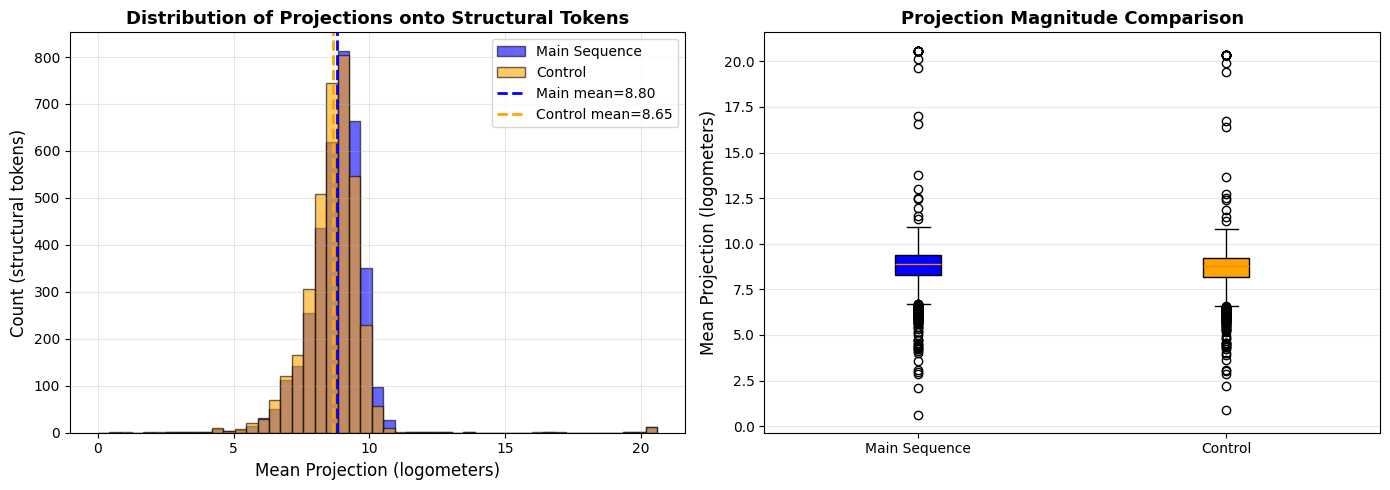

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
ax = axes[0]
bins = np.linspace(0, max(main_seq_proj_array.max(), control_proj_array.max()), 50)
ax.hist(main_seq_proj_array, bins=bins, alpha=0.6, label='Main Sequence', color='blue', edgecolor='black')
ax.hist(control_proj_array, bins=bins, alpha=0.6, label='Control', color='orange', edgecolor='black')
ax.axvline(main_mean, color='blue', linestyle='--', linewidth=2, label=f'Main mean={main_mean:.2f}')
ax.axvline(control_mean, color='orange', linestyle='--', linewidth=2, label=f'Control mean={control_mean:.2f}')
ax.set_xlabel('Mean Projection (logometers)', fontsize=12)
ax.set_ylabel('Count (structural tokens)', fontsize=12)
ax.set_title('Distribution of Projections onto Structural Tokens', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Box plot comparison
ax = axes[1]
data = [main_seq_proj_array, control_proj_array]
bp = ax.boxplot(data, labels=['Main Sequence', 'Control'], patch_artist=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('orange')
ax.set_ylabel('Mean Projection (logometers)', fontsize=12)
ax.set_title('Projection Magnitude Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Breakdown by Structural Token Category

In [11]:
# Group projections by structural token category
from collections import defaultdict

category_projections = defaultdict(list)

for proj, reason in zip(main_seq_projections_all, structural_reasons):
    category_projections[reason].append(proj)

print("Mean projection by structural token category:")
print("="*70)
print(f"{'Category':<20s} {'Count':>8s} {'Mean Proj':>12s} {'Std':>10s}")
print("-"*70)

for reason in sorted(category_projections.keys()):
    projs = np.array(category_projections[reason])
    mean_proj = projs.mean()
    std_proj = projs.std()
    count = len(projs)
    print(f"{reason:<20s} {count:>8d} {mean_proj:>12.4f} {std_proj:>10.4f}")

print()
print("This breakdown shows whether certain types of structural tokens")
print("(e.g., whitespace vs. special tokens) are more or less orthogonal.")

Mean projection by structural token category:
Category                Count    Mean Proj        Std
----------------------------------------------------------------------
control_char             3200       8.7926     0.9067
marker_format               6      13.9829     3.0316
special_token              14      18.6210     5.1632
whitespace                441       8.4369     1.3835

This breakdown shows whether certain types of structural tokens
(e.g., whitespace vs. special tokens) are more or less orthogonal.


## Summary

This notebook tests whether the "structure ⊥ content" finding from 04.6a3 generalizes to ALL structural tokens, not just the 3 extreme quasars.

**Key question answered**: Do typical semantic tokens (main sequence) lie in a subspace causally orthogonal to the ENTIRE structural token subspace?

**Next steps**:
- If strong orthogonality confirmed: Update notes to reflect general principle
- If weak/no orthogonality: Structural separation may be limited to extreme outliers
- Category breakdown reveals which types of structural tokens show strongest separation